# 1. Introduction

## 1.1 More intro later....

# 2. Importing modules and data preprocessing

In [210]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from keras.utils.np_utils import to_categorical
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

In [211]:
df = pd.read_csv("./data/training_set_metadata.csv")
selected_features = ['ra', 'decl', 'gal_l', 'gal_b', 'ddf', 'hostgal_specz', 'hostgal_photoz', 'distmod', 'mwebv', 'target']

In [212]:
df = pd.DataFrame(df, columns = selected_features)
df.head(5)

,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,distmod,mwebv,target
0,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,NaN,0.017,92
1,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,45.4063,0.007,88
2,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,40.2561,0.021,42
3,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,40.7951,0.007,90
4,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,40.4166,0.024,90


In [213]:
num_targets = df['target'].nunique() # 14 classes of objects as it had been written in docs

In [214]:
unique_targets = df['target'].unique() # unique classes
encoder = LabelEncoder()
unique_targets = encoder.fit_transform(unique_targets)

In [215]:
map_dictionary = dict(zip(encoder.classes_, unique_targets))
map_dictionary

{6: 12,
 15: 10,
 16: 3,
 42: 11,
 52: 8,
 53: 2,
 62: 9,
 64: 13,
 65: 6,
 67: 1,
 88: 4,
 90: 0,
 92: 7,
 95: 5}

In [216]:
def reduce_navalues(dataframe, cols):
    for col in cols:
        if col == 'target':
            continue
        df[col] = df[col].fillna(df[col].mean()).astype(float)

In [217]:
reduce_navalues(df, selected_features)
df.head(5)

,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,distmod,mwebv,target
0,349.046051,-61.943836,320.796530,-51.753706,1.0,0.0000,0.0000,41.263961,0.017,92
1,53.085938,-27.784405,223.525509,-54.460748,1.0,1.8181,1.6267,45.406300,0.007,88
2,33.574219,-6.579593,170.455585,-61.548219,1.0,0.2320,0.2262,40.256100,0.021,42
3,0.189873,-45.586655,328.254458,-68.969298,1.0,0.3037,0.2813,40.795100,0.007,90
4,352.711273,-63.823658,316.922299,-51.059403,1.0,0.1934,0.2415,40.416600,0.024,90


In [218]:
def count_by_value(df, col = 'target', class_numbers = 14):
    unique_targets = df['target'].values
    list_counters = [0] * class_numbers
    for target in unique_targets:
        number_of_target = df[col][df[col] == target].value_counts().values
        mapped_index = map_dictionary[target]
        list_counters[mapped_index] = number_of_target[0]
    return np.array(list_counters)

In [219]:
counter_list = count_by_value(df)

In [220]:
#Create X, Y np.arrays
X = df.iloc[:, :-1].values
Y = df.iloc[:, -1].values

In [221]:
scaler = StandardScaler()
encoder = LabelEncoder()
X = scaler.fit_transform(X)
Y = encoder.fit_transform(Y)
Y= to_categorical(Y, 14)

In [222]:
def plot_histogram(X , Y):
    plt.style.use("dark_background")
    plt.figure(figsize=(12, 8))
    plt.xlabel("Object class mapped from oryginal")
    plt.ylabel("The number of the object in the dataset")
    plt.title("Checking the number of objects belonging to the particular classes")
    plt.bar(X, Y, label = "The number of a particular astronimical object", color = "#f1f1f1")

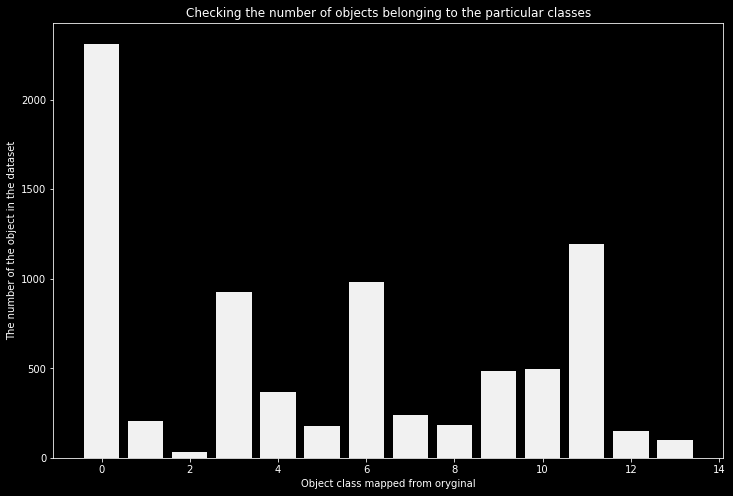

In [223]:
plot_histogram(list(range(0, 14)), counter_list)

In [224]:
#Clustering
def pick_clusters_number(dataset, iterations):
    wcss = []
    for i in range(1, iterations + 1):
        kmeans = KMeans(n_clusters = i, init = 'k-means++',max_iter = 300,n_init = 10,random_state = 0)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
    plt.figure(figsize= ((16,10)))
    plt.plot(range(1, iterations + 1), wcss)
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

In [225]:
def show_dendrogram(features):
    plt.figure(figsize= (16,10))
    dendrogram = sch.dendrogram(sch.linkage(features, method = 'ward'))
    plt.title('Dendrogram')
    plt.show()

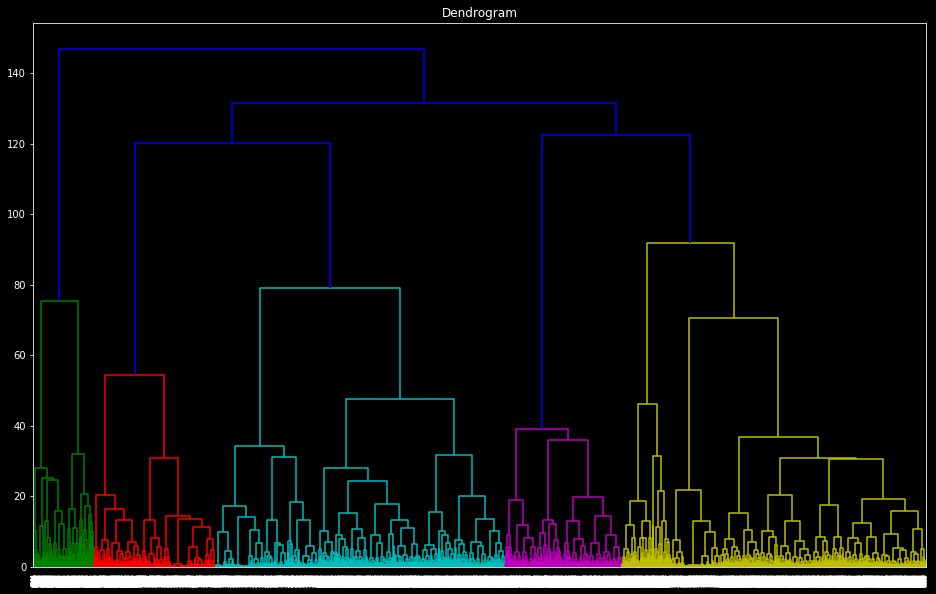

In [226]:
show_dendrogram(X)

In [227]:
hc = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(X) #clusters' vector

In [369]:
def visualise_distribution_of_objects_in_clusters(df = df, n_clusters = 5,
                                color_palette = ["#FF5733", "#E3E32D", "#33C9FF", "#0F14FF", "#4033FF", "#E2002D", "#7F97FF", "#32CD32", 
                                                 "#00CED1", "#FF1493", "#ffffcc", "#CA00CA", "#5C5C18", "#AB03A6"]):
    cluster_list = np.array(list(range(0, n_clusters)))
    plt.figure(figsize = (12, 8))
    it = 0
    for target in df['target'].unique(): 
        specified_targets = df['cluster'][df['target'] == target].value_counts()
        distribution = [0] * n_clusters
        for cluster in specified_targets.index: #indexes are clusters' possible values
            distribution[cluster] = specified_targets[cluster]
        if it == 7:
              plt.figure(figsize = (12, 8))
        plt.legend(loc=1, prop={'size': 16}, frameon=True,shadow=True, edgecolor="#f1f1f1")
        plt.xlabel("Cluster value")
        plt.ylabel("The number of objects per each cluster")
        plt.title("Distrubution of objects in created clusters")
        plt.bar(cluster_list, distribution, width = 0.3, label = "Target ID:{}".format(target), color = color_palette[it] )
        it += 1
        

No handles with labels found to put in legend.
No handles with labels found to put in legend.


14


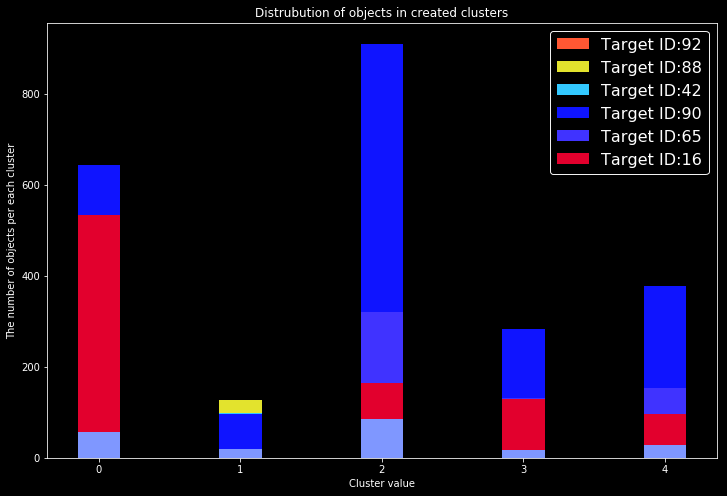

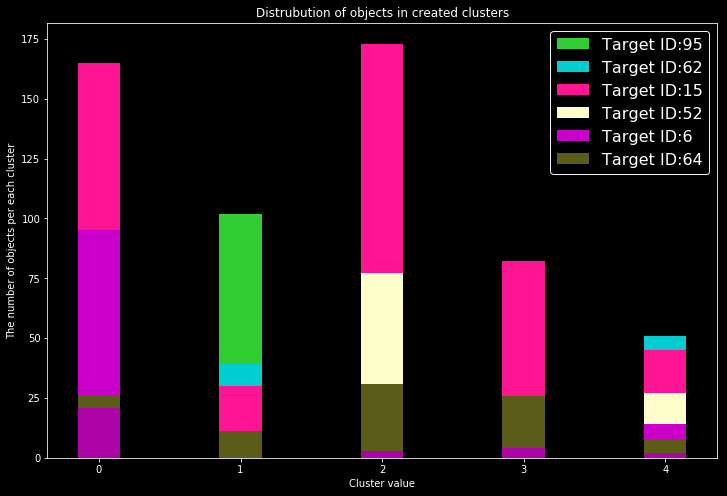

In [370]:
visualise_distribution_of_objects_in_clusters(df = df)